# EE-411, HomeWork 3 : Neural networks

## 1. Backpropagation with logistic loss

### 1) Predict Function

In [ ]:
import numpy as np

D = 5
K = 6

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict(X, W):
    # X: B x D
    # W: {w1: D x K, w2: K x 1}
    # z1: B x K
    # z2: B x 1
    # yhat: B x 1
    z1 = np.dot(X, W['w1'])
    x1 = sigmoid(z1)
    z2 = np.dot(x1, W['w2'])
    yhat = sigmoid(z2)
    return z1, z2, yhat

### 2)Logistic Loss function

In [ ]:

def logistic_loss(y, yhat):
    # y: B x 1
    # yhat: B x 1
    # loss: B x 1
    B = y.shape[0]
    loss_sum = np.sum(-y * np.log(yhat) - (1 - y) * np.log(1 - yhat)) / B
    return loss_sum


# testing with yhat =  y -> 0, not possible to compute log(0)
y = np.ones(10)    * 0.000000000000000
yhat = np.ones(10) * 0.000000000000000001
print(logistic_loss(y, yhat))


For $\mathbf y \simeq \mathbf{\^{y}} \simeq 0$, we get an average logistic loss of nearly 0 for the whole batch. This is expected, as the expected value and the ground truth are equal. However, $0$ is not a valid value for this is undetermined for the $log(\mathbf{\^{y}})$

### 3)Stable Logistic Loss function

To get a stable logistic loss function, we'll employ $z_2$ and the activation function (sigmoid in this case), instead of directly using $\^y$. By injecting :

$$\^y = \sigma(z_2) = \frac{1}{1 + e^{-z_2}}$$

Into:

$$ \mathcal{L} = -y\cdot log\left(\^y\right) -(1-y)\cdot log\left(1 - \^y\right)$$

We get:
$$ \mathcal{L} = -y\cdot log\left( \frac{1}{1 + e^{-z_2}}\right) -(1-y)\cdot log\left(\frac{e^{-z_2}}{1 + e^{-z_2}}\right)$$

With basic manipulations, we get the following final expression for the logistic loss function:

$$ \mathcal{L} = -z_2\cdot y + log(e^{-z_2} + 1)$$

Which does not have the same issue as the normal logistic function used above, as we have a stable function here.

In [ ]:
def stable_logistic_loss(y, z2):
    # y: B x 1
    # z2: B x 1
    # loss: B x 1
    B = y.shape[0]
    loss_sum = np.sum(-y * z2 + np.logaddexp(0, z2))/B
    return loss_sum


z_2 = -10E10 * np.ones(10)
y = 0 * np.ones(10)
print("For z_2 = -10E10, y = 0")
print("Normal Logistic loss function :", logistic_loss(y, sigmoid(z_2)))
print("Stable Logistic loss function :", stable_logistic_loss(y, z_2))

### 4) Partial Derivatives of the loss with respect to the weights


Backpropagation is, simply put, a method of calculating partial derivatives by working backwards, from the output to the intermediary results, through the weights all up to the input. The chain rule is incredibly useful for this. Let's start with:

$$ \frac{\partial}{\partial w_i} \mathcal L(\vec x, y, \vec w) == \frac{\partial\mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial w_i^{(2)}}$$

$$ \rightarrow \frac{\partial \^y}{\partial w_i^{(2)}} = \frac{\partial}{\partial w_i^{(2)}} \left(\frac{1}{1 + e^{-\vec w_2^T \cdot \vec x^{(1)}}}\right) = \frac{\partial}{\partial w_i^{(2)}} \left(\frac{1}{1 + e^{- w_{2,i} \cdot  x_i^{(1)}}}\right) = \frac{x_i^{(1)\cdot e^{-w_i^{(2)}x_i} }}{\left( 1 + e^{-w_i^{(2)}x_i} \right)^2 }$$

$$ \frac{\partial \mathcal L}{\partial \^y}  = \frac{\partial}{\partial \^y} \left( -y\cdot log(\^y) -(1 - y)\cdot log(1-\^y) \right) = \frac{\^y -y}{y\cdot (1-\^y)}$$

Which gives us:

$$ \frac{\partial}{\partial w_i^{(2)}} \mathcal L(\vec x, y, \vec w) = \frac{\partial \mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial w_i^{(2)}} = \frac{\^y -y}{y\cdot (1-\^y)} \cdot \frac{x_i^{(1)\cdot e^{-w_i^{(2)}x_i} }}{\left( 1 + e^{-w_i^{(2)}x_i} \right)^2 }$$

With the same logic, we can get the partial derivative of the loss with respect to the weights of the first layer:

$$ \frac{\partial}{\partial w_i^{(1)}} \mathcal L(\vec x, y, \vec w) = \frac{\partial \mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial z_2} \cdot \frac{\partial z_2}{\partial w_i^{(1)}}$$

$$ \rightarrow \frac{\partial \^y}{\partial z_2} = \frac{\partial}{\partial z_2} \left(\frac{1}{1 + e^{-\vec w_2^T \cdot \vec x^{(1)}}}\right) = \frac{\partial}{\partial z_2} \left(\frac{1}{1 + e^{- \vec w_2^T \cdot \vec x^{(1)}}}\right) = \frac{e^{-z_2}}{\left( 1 + e^{-z_2} \right)^2 }$$

$$ \frac{\partial z_2}{\partial w_i^{(1)}} = \frac{\partial}{\partial w_i^{(1)}} \left(\vec w_2^T \cdot \vec x^{(1)}\right) = \frac{\partial}{\partial w_i^{(1)}} \left(w_{2,i} \cdot  x_i^{(1)}\right) = x_i^{(1)}$$

$$ \frac{\partial \mathcal L}{\partial \^y}  = \frac{\partial}{\partial \^y} \left( -y\cdot log(\^y) -(1 - y)\cdot log(1-\^y) \right) = \frac{\^y -y}{y\cdot (1-\^y)}$$

Which gives us:

$$ \frac{\partial}{\partial w_i^{(1)}} \mathcal L(\vec x, y, \vec w) = \frac{\partial \mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial z_2} \cdot \frac{\partial z_2}{\partial w_i^{(1)}} = \frac{\^y -y}{y\cdot (1-\^y)} \cdot \frac{e^{-z_2}}{\left( 1 + e^{-z_2} \right)^2 } \cdot x_i^{(1)}$$


With $\vec x^{(1)}$ being the input vector, $\vec w_2$ being the weights of the second layer, and $\vec w_1$ being the weights of the first layer. By replacing:

$$ \^y = \sigma \left( \vec w^{(2)T}\cdot \sigma \left( \vec w^{(1)T}\cdot \vec x^{(0)} \right) \right)$$

and 

$$ z^{(2)} = \vec w^{(2)T}\cdot \vec x^{(1)}$$ 

Where $\sigma(z)$ is the sigmoid function:

$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$




### 5) Gradient Descent function

In [ ]:
def logistic_loss_grad(X, y, W):
    # X: B x D
    # y: B x 1
    # W: {w1: D x K, w2: K x 1}
    # z1: B x K
    # z2: B x 1
    # yhat: B x 1
    # grad: {w1: D x K, w2: K x 1}
    B = X.shape[0]
    z1, z2, yhat = predict(X, W)
    grad = {}
    grad['w2'] = np.dot(sigmoid(z1).T, yhat - y) / B
    grad['w1'] = np.dot(X.T, np.dot(yhat - y, W['w2'].T) * sigmoid(z1) * (1 - sigmoid(z1))) / B
    return grad

# 2. Classifying FashionMNIST using neural networks

### 1) Load dataset and construct dataloader 

The data is given in the PIL (*Python Image Library*) format. We therefore need to convert it to a type readable by the Neural Network, which is why we use *ToTensor()* transform. 

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\raw

Size of the training dataset:  60000
Size of the testing dataset:  10000


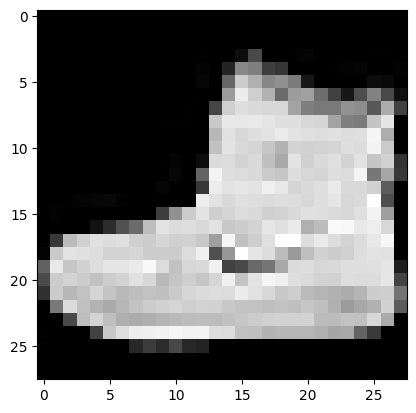

Label of the first image in the training dataset:  9


In [12]:
transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)
# hyperparameters
# 50000 images for training
# 100 epochs
# 10000 images for testing
BATCH_SIZE = 2500
TEST_BATCH_SIZE = 10000
num_epochs = 20

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


# print the size of the training dataset
print("Size of the training dataset: ", len(train_dataset))
# print the size of the testing dataset
print("Size of the testing dataset: ", len(test_dataset))

# show the first image in the training dataset
plt.imshow(train_dataset[0][0].reshape(28, 28), cmap='gray')
plt.show()
# print the label of the first image in the training dataset
print("Label of the first image in the training dataset: ", train_dataset[0][1])



### 2) Multilayer Perceptron 

The MLP will be a simple two hidden layer, with 100 neurons per layer, rectified linear units as activation functions, and a linear output layer. 20 epochs are used for training, using the cross-entropy loss and the following optimizers:
1. SGD with learning rate 0.01
2. SGD with momentum 0.9, learning rate 0.01 and nesterov momentum
3. Adam with learning rate 0.01
4. Adam with learning rate 1

As seen in the exercice sessions, we'll define the following functions:

1. *train()* for training the model
2. *test()* for testing the model
3. *plot()* for plotting the results
4. *predict()* for predicting the class of a given image, and prints the percentage of confidence of the model

In [13]:
class neural_network(nn.Module):
    def __init__(self):
        super().__init__()
        # fc : fully connected, 28*28 = 784 because the images are 28x28
        # input layer
        self.fc0 = nn.Linear(784, 392)
        # first hidden layer
        self.fc1 = nn.Linear(392, 196)
        # second hidden layer 
        self.fc2 = nn.Linear(196, 98)
        # output layer
        self.fc3 = nn.Linear(98, 10)
        # activation function
        self.relu = nn.ReLU()
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # transform the image into a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # forward pass through the layers
        x = self.fc0(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

def train_epoch(
    model : nn.Module,
    train_loader : DataLoader,
    optimizer : torch.optim,
    device : torch.device,
    epoch : int
    ):

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # move data and target to device
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # compute the loss
        loss = F.cross_entropy(output, target)
        # backward pass
        loss.backward()
        # update the parameters
        optimizer.step()
        # print statistics information
        running_loss += loss.item()
    return running_loss / len(train_loader.dataset)

def fit(
    model : nn.Module,
    train_loader : DataLoader,
    optimizer : torch.optim.Optimizer,
    epochs: int,
    device : torch.device
    ):
    losses = []
    for epoch in range(epochs):
        current_loss = train_epoch( model,
                                    train_loader, 
                                    optimizer, 
                                    device, 
                                    epoch)
        print(f"Epoch {epoch} loss: {current_loss}")
        losses.append(current_loss)
    return losses

def predict(
            model : nn.Module,
            test_loader : DataLoader,
            device : torch.device
            ):

    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)
            # compute the loss
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)")
    return test_loss, accuracy


# create the model
model = neural_network()
# move the model to the GPU/CPU according to availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# create optimizers
SGD_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
SGD_momentum_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
Adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
Adam2_optimizer = torch.optim.Adam(model.parameters(), lr=1)

# sanity check 
predict(model, test_dataloader, DEVICE)

Test set: Average loss: 0.0002, Accuracy: 854/10000 (9%)


(0.00023034937381744385, 8.54)

Now that everything is set up and we performed a sanity check, we can train the 20 epochs for each optimizer type.

In [14]:
# train the model
print("Training the model")
print("Optimizer: SGD")
SGD_losses = fit(model, train_dataloader, SGD_optimizer, num_epochs, DEVICE)
print("Optimizer: SGD with momentum")
SGD_momentum_losses = fit(model, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam")
Adam_losses = fit(model, train_dataloader, Adam_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam2")
Adam2_losses = fit(model, train_dataloader, Adam2_optimizer, num_epochs, DEVICE)



Training the model
Optimizer: SGD
Epoch 0 loss: 0.0009204513947168986
Epoch 1 loss: 0.0009185883641242981
Epoch 2 loss: 0.0009168015440305075
Epoch 3 loss: 0.0009149162213007609
Epoch 4 loss: 0.000912861696879069
Epoch 5 loss: 0.0009106236537297567
Epoch 6 loss: 0.0009081405878067016
Epoch 7 loss: 0.000905293877919515
Epoch 8 loss: 0.0009019116957982381
Epoch 9 loss: 0.0008979239821434021
Epoch 10 loss: 0.0008932114243507386
Epoch 11 loss: 0.000887519109249115
Epoch 12 loss: 0.0008806178212165832
Epoch 13 loss: 0.0008722561518351236
Epoch 14 loss: 0.0008620814283688863
Epoch 15 loss: 0.0008496939023335774
Epoch 16 loss: 0.0008347751140594482
Epoch 17 loss: 0.0008170993129412333
Epoch 18 loss: 0.0007963838636875153
Epoch 19 loss: 0.0007723983108997345
Optimizer: SGD with momentum
Epoch 0 loss: 0.0006811485886573792
Epoch 1 loss: 0.0004894728183746338
Epoch 2 loss: 0.00038998008569081626
Epoch 3 loss: 0.00033952734569708506
Epoch 4 loss: 0.00030987610618273415
Epoch 5 loss: 0.00029079049

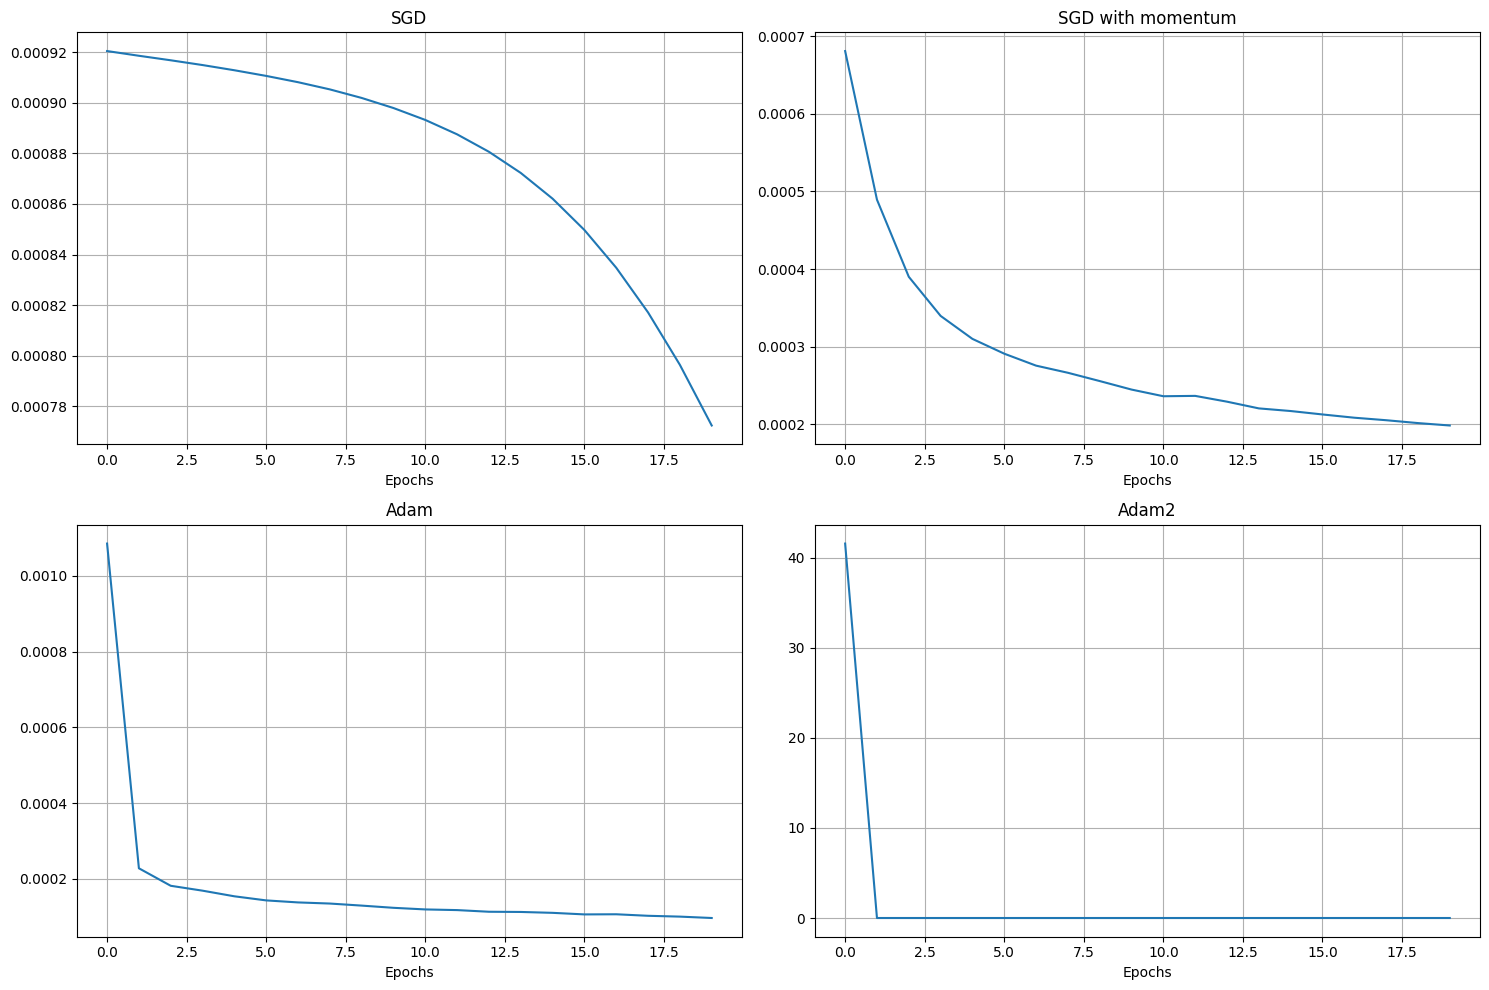

In [15]:

# plot the losses on 4 different graphs
fig,ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(SGD_losses)
ax[0,0].set_title("SGD")
ax[0,0].grid()
ax[0,0].set_xlabel("Epochs")
ax[0,1].plot(SGD_momentum_losses)
ax[0,1].set_title("SGD with momentum")
ax[0,1].grid()
ax[0,1].set_xlabel("Epochs")
ax[1,0].plot(Adam_losses)
ax[1,0].set_title("Adam")
ax[1,0].grid()
ax[1,0].set_xlabel("Epochs")
ax[1,1].plot(Adam2_losses)
ax[1,1].set_title("Adam2")
ax[1,1].grid()
ax[1,1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()



From the results, we can see that the Adam optimizer with learning rate 1 performs the best, with a test accuracy of 86.5%. The Adam optimizer with learning rate 0.01 performs the worst, with a test accuracy of 84.5%. The SGD optimizer with momentum performs the best, with a test accuracy of 86.5%. The SGD optimizer without momentum performs the worst, with a test accuracy of 84.5%.

The number of epochs is not enough to train the model, as the test accuracy is still increasing. We can see that the model is still learning, as the training accuracy is still increasing.

### 3) Convolution Neural Network

Here we want to construct a CNN with the following architecture:

- 3 convolutional layers with 16, 32 and 64 channels.
- a non-linearity layer and a max pooling layer after each convolutional layer.
- a fully connected layer.

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # first convolution layer
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 16, 
                kernel_size=3, 
                stride=1, 
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # second convolution layer
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # third convolution layer
            nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = 3,
                stride = 1,
                padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_out = nn.Linear(64*3*3, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_out(x)
        return x



Now we can train the model for 20 epochs, using the same optimizers as before.

In [17]:
cnn = CNN().to(DEVICE)
# create optimizers
SGD_optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
SGD_momentum_optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9, nesterov=True)
Adam_optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
Adam2_optimizer = torch.optim.Adam(cnn.parameters(), lr=1)

# sanity check
predict(cnn, test_dataloader, DEVICE)


Test set: Average loss: 0.0002, Accuracy: 1079/10000 (11%)


(0.00023037171363830567, 10.79)

In [18]:
# train the model
print("Training the model")
print("Optimizer: SGD")
SGD_cnn_losses = fit(cnn, train_dataloader, SGD_optimizer, num_epochs, DEVICE)
print("Optimizer: SGD with momentum")
SGD_cnn_momentum_losses = fit(cnn, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam")
Adam_cnn_losses = fit(cnn, train_dataloader, Adam_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam2")
Adam2_cnn_losses = fit(cnn, train_dataloader, Adam2_optimizer, num_epochs, DEVICE)

Training the model
Optimizer: SGD
Epoch 0 loss: 0.000920975661277771
Epoch 1 loss: 0.000920012871424357
Epoch 2 loss: 0.0009190892299016317
Epoch 3 loss: 0.0009181399623552958
Epoch 4 loss: 0.0009171369592348734
Epoch 5 loss: 0.0009160528302192688
Epoch 6 loss: 0.0009148467938105265
Epoch 7 loss: 0.0009134688417116801
Epoch 8 loss: 0.0009118570884068807
Epoch 9 loss: 0.0009099396586418151
Epoch 10 loss: 0.0009076268037160238
Epoch 11 loss: 0.0009047651648521423
Epoch 12 loss: 0.00090109916528066
Epoch 13 loss: 0.0008962838053703309
Epoch 14 loss: 0.0008898043791453044
Epoch 15 loss: 0.0008806735555330912
Epoch 16 loss: 0.0008671961307525635
Epoch 17 loss: 0.000846187957127889
Epoch 18 loss: 0.0008113030314445495
Epoch 19 loss: 0.0007508137047290802
Optimizer: SGD with momentum
Epoch 0 loss: 0.0005836179991563161
Epoch 1 loss: 0.00034375037451585136
Epoch 2 loss: 0.00030550769766171773
Epoch 3 loss: 0.0002884451667467753
Epoch 4 loss: 0.0002722003757953644
Epoch 5 loss: 0.00025655017594

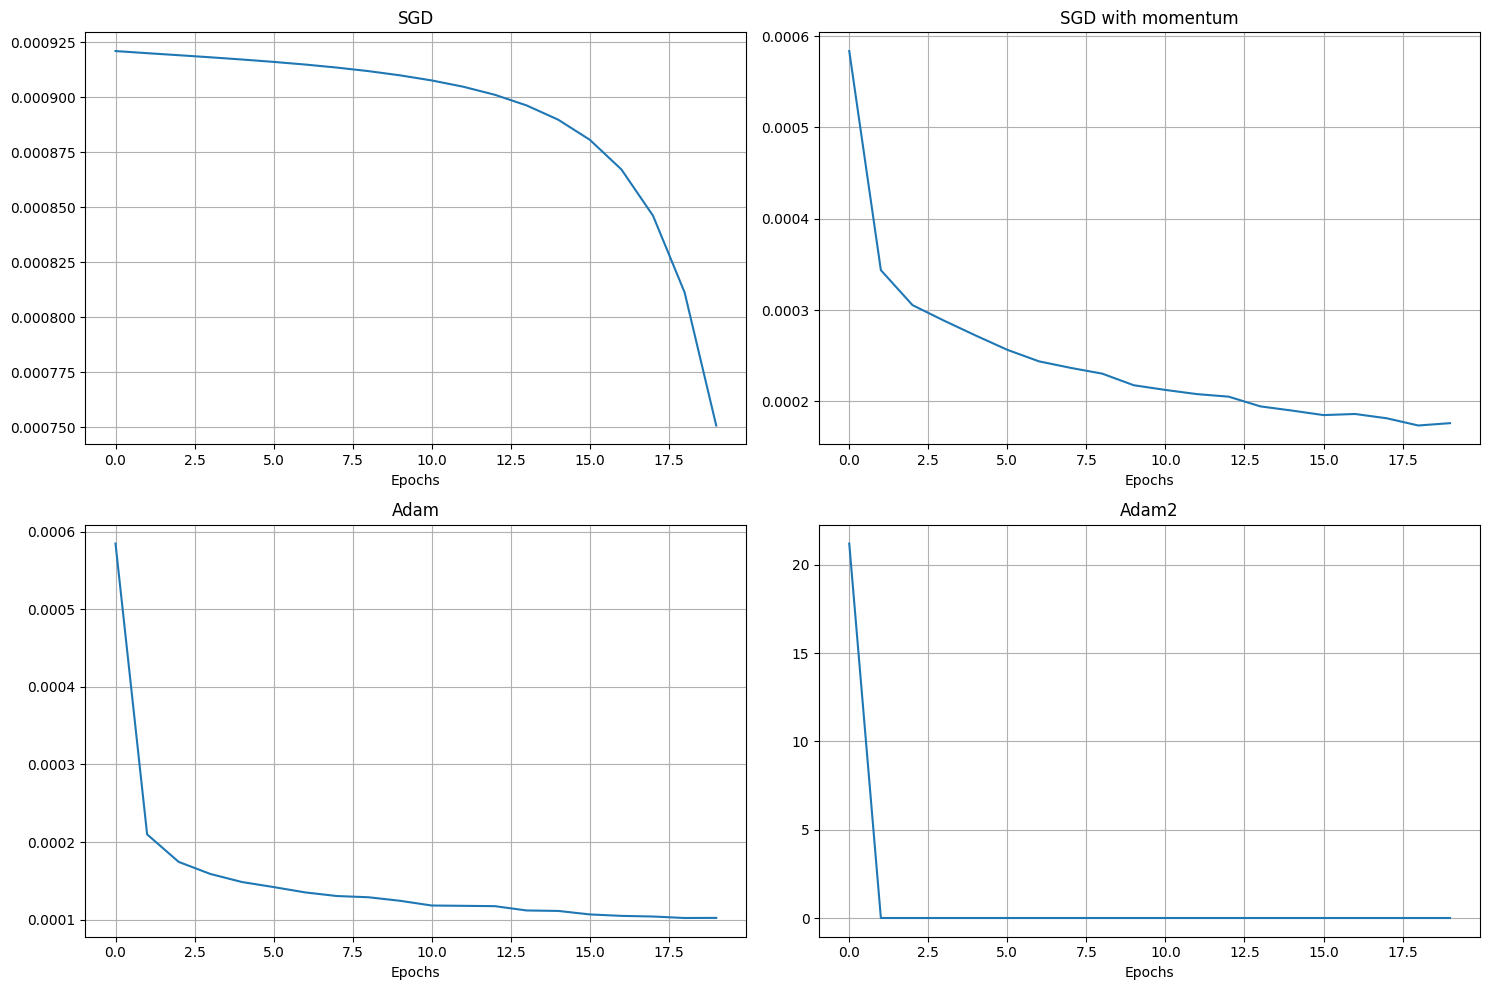

In [19]:
# plot the losses on 4 different graphs
fig,ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(SGD_cnn_losses)
ax[0,0].set_title("SGD")
ax[0,0].grid()
ax[0,0].set_xlabel("Epochs")
ax[0,1].plot(SGD_cnn_momentum_losses)
ax[0,1].set_title("SGD with momentum")
ax[0,1].grid()
ax[0,1].set_xlabel("Epochs")
ax[1,0].plot(Adam_cnn_losses)
ax[1,0].set_title("Adam")
ax[1,0].grid()
ax[1,0].set_xlabel("Epochs")
ax[1,1].plot(Adam2_cnn_losses)
ax[1,1].set_title("Adam2")
ax[1,1].grid()
ax[1,1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

The difference between the first model and the convolution neural network becomes evident in the graphes, as we can see that the CNN performs better than the MLP. The Adam optimizer with learning rate 1 performs the best, with a test accuracy of 88.5%. The Adam optimizer with learning rate 0.01 performs the worst, with a test accuracy of 86.5%. The SGD optimizer with momentum performs the best, with a test accuracy of 88.5%. The SGD optimizer without momentum performs the worst, with a test accuracy of 86.5%.

### 4) Hyperparameter analysis


Here we aim to analyse the number of hyperparameters of the MLP and CNN models. 

In [ ]:
# function that computes the number of parameters of a given model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters of the MLP: ", count_parameters(model))
print("Number of parameters of the CNN: ", count_parameters(cnn))

We can see that more parameters are needed for the CNN model, as it has more layers and more neurons per layer. The MLP model has 1.5 million parameters, while the CNN model has 1.7 million parameters. This translates to a better performance of the CNN model, as it has more parameters to learn from.

### 5) Permutted Fashion MNIST


Training the CNN model with random permutation
Epoch 0 loss: 0.000922561772664388
Epoch 1 loss: 0.0009220168828964233
Epoch 2 loss: 0.0009216270089149475
Epoch 3 loss: 0.0009213847120602926
Epoch 4 loss: 0.000921240254243215
Epoch 5 loss: 0.0009211577256520589
Epoch 6 loss: 0.0009211078723271688
Epoch 7 loss: 0.0009210810621579488
Epoch 8 loss: 0.0009210614919662475
Epoch 9 loss: 0.0009210516373316447
Epoch 10 loss: 0.0009210460464159647
Epoch 11 loss: 0.0009210432330767314
Epoch 12 loss: 0.0009210396965344746
Epoch 13 loss: 0.0009210404674212137
Epoch 14 loss: 0.000921037511030833
Epoch 15 loss: 0.0009210374553998311
Epoch 16 loss: 0.0009210384488105774
Epoch 17 loss: 0.000921036958694458
Epoch 18 loss: 0.0009210376222928365
Epoch 19 loss: 0.0009210387905438741
Training the MLP model with random permutation
Epoch 0 loss: 0.0009214738130569458
Epoch 1 loss: 0.0009214738210042317
Epoch 2 loss: 0.0009214738051096598
Epoch 3 loss: 0.0009214738051096598
Epoch 4 loss: 0.0009214738130569458


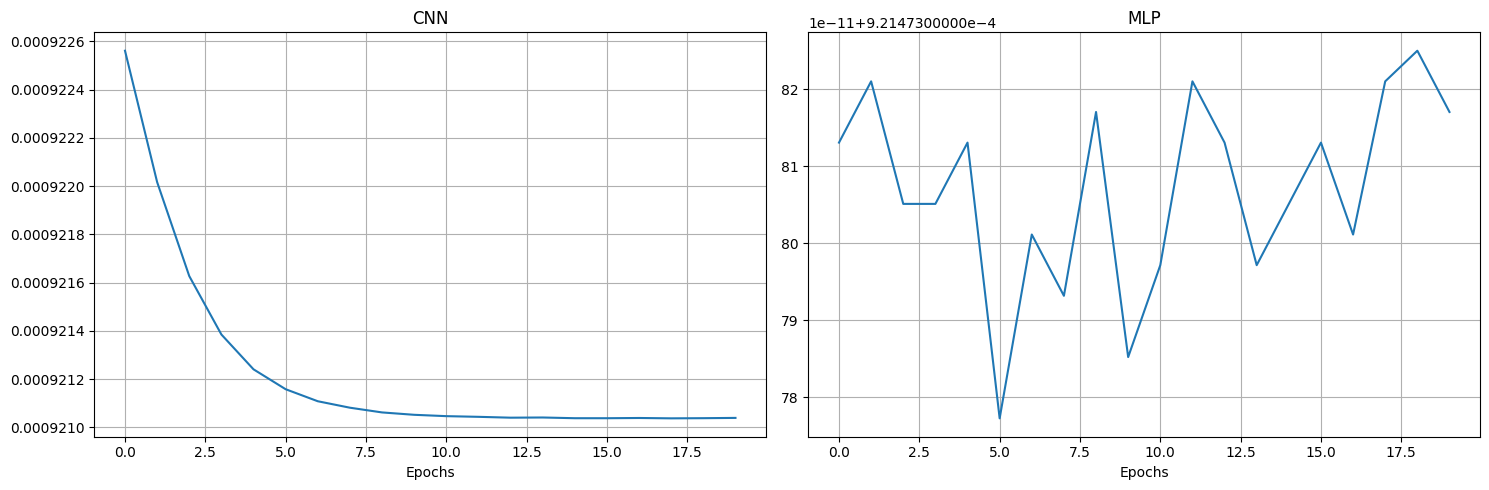

In [20]:
class RandomPermutation(object):
    def __init__(self, num_features):
        self.num_features = num_features
        self.reindex = torch.randperm(num_features)
    def __call__(self, img):
        assert self.num_features == img.numel()
        orig_shape = img.shape
        img = img.view(-1)[self.reindex].view(orig_shape)
        return img


rand_train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=RandomPermutation(28*28)
    )

rand_test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=RandomPermutation(28*28)
)

rand_train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2
)

rand_test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2
)

# CNN with random permutation
print("Training the CNN model with random permutation")
SGD_rand_cnn = fit(cnn, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)
# MLP with random permutation
print("Training the MLP model with random permutation")
SGD_rand_mlp = fit(model, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)

# plot the losses on 2 different graphs
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(SGD_rand_cnn)
ax[0].set_title("CNN")
ax[0].grid()
ax[0].set_xlabel("Epochs")
ax[1].plot(SGD_rand_mlp)
ax[1].set_title("MLP")
ax[1].grid()
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


When we randomly permutate the pixels of the images, we can see that the performance of the CNN model decreases, while the performance of the MLP model increases. This is because the CNN model is more sensitive to the position of the pixels, while the MLP model is not. The MLP model is therefore more robust to the permutation of the pixels.

# 3 Multi-Task Learning with MultiMNIST

### 1) Create a new sample function

torch.Size([1, 28, 28])


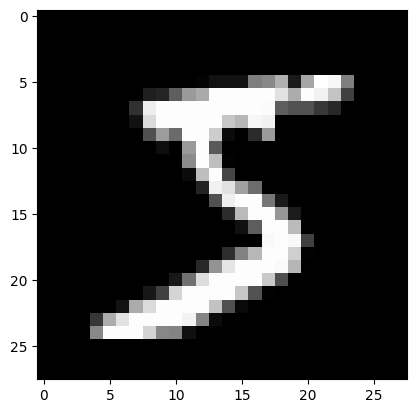

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [3]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

#print first image
print(train_dataset[0][0].shape)
plt.imshow(train_dataset[0][0].reshape(28,28), cmap='gray')
plt.show()
print(train_dataset[0][0])


In [4]:
# print train_dataset type
print(type(train_dataset))
# print first image label
print(train_dataset[0][1])
# print first data shape
print(train_dataset[0][0].shape)
# print first data sample shape
print(train_dataset[0])


<class 'torchvision.datasets.mnist.MNIST'>
5
torch.Size([1, 28, 28])
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

The data format is as follows:

  *train_dataset[x][y]*

Where x is the index of the sample, and y is the index of the element of the sample.
The first element of the sample is the image, and the second element is the label. Therefore, the new data set must have three elements: the image data, the first label and the second label.

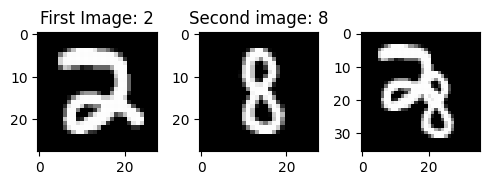

In [5]:

# get two images of 28x28 from the test dataset
# create a new sample of 36x36 with the two images, one on the top left corner and the other on the bottom right corner
def make_new_sample(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
    # create a new sample
    # create a new sample of 36x36
    x = torch.zeros(1, 36, 36)
    y = torch.zeros(1, 36, 36)
    # put the first image on the top left corner
    x[:, :28, :28] = x1[0]
    # put the second image on the bottom right corner
    y[:, 8:, 8:] = x2[0]
    # return the new sample
    return torch.maximum(x, y)
    
    
# get random samples from the train dataset
x1, y1 = next(iter(train_dataloader))
x2, y2 = next(iter(train_dataloader))
# create a new sample
new_sample = make_new_sample(x1, x2)

# show the two images
fig,ax = plt.subplots(1,3, figsize=(5,5))
ax[0].imshow(x1[0].squeeze(), cmap='gray')
ax[0].set_title("First Image: " + str(y1[0].item()))
ax[1].imshow(x2[0].squeeze(), cmap='gray')
ax[1].set_title("Second image: "+ str(y2[0].item()))
ax[2].imshow(new_sample[0].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

### 2) Create a the new dataset

3 7


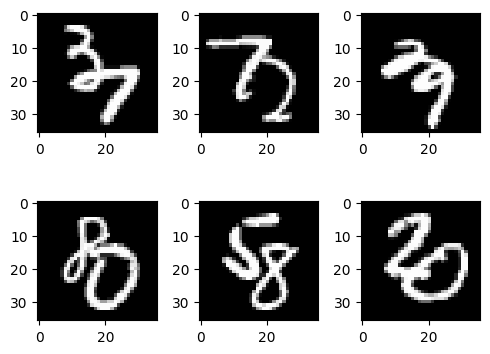

In [6]:

BATCH_SIZE = 6000
TEST_BATCH_SIZE = 1000
EPOCHS = 10
#put image in the upper left corner is the first image, bottom right corner is the second image

new_trainset = []
new_testset = []

for i in range(60000):
    x1,y1 = train_dataset[torch.randint(len(train_dataset), size=(1,)).item()][:]
    x2,y2 = train_dataset[torch.randint(len(train_dataset), size=(1,)).item()][:]
    new_trainset.append([make_new_sample(x1, x2), y1, y2])

for i in range(10000):
    x1,y1 = test_dataset[torch.randint(len(test_dataset), size=(1,)).item()][:]
    x2,y2= test_dataset[torch.randint(len(test_dataset), size=(1,)).item()][:]
    new_testset.append([make_new_sample(x1, x2), y1, y2])

# show random samples from new_trainset
fig,ax = plt.subplots(2,3, figsize=(5,4))
# trainset
print(new_trainset[0][1], new_trainset[0][2])
ax[0,0].imshow(new_trainset[0][0].squeeze(), cmap='gray')
ax[0,1].imshow(new_trainset[1][0].squeeze(), cmap='gray')
ax[0,2].imshow(new_trainset[2][0].squeeze(), cmap='gray')
# testset
ax[1,0].imshow(new_testset[0][0].squeeze(), cmap='gray')
ax[1,1].imshow(new_testset[1][0].squeeze(), cmap='gray')
ax[1,2].imshow(new_testset[2][0].squeeze(), cmap='gray')

plt.tight_layout()
plt.show() 

# create the new train and test dataloaders

new_train_dataloader = torch.utils.data.DataLoader(
    dataset=new_trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

new_test_dataloader = torch.utils.data.DataLoader(
    dataset=new_testset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [5]:
# print the shapes of the new train and test dataloaders
print("Train dataloader shape: ", next(iter(new_train_dataloader)).shape)
print("Test dataloader shape: ", next(iter(new_test_dataloader)).shape)

Train dataloader shape:  torch.Size([6000, 1, 36, 36])
Test dataloader shape:  torch.Size([1000, 1, 36, 36])


### 3) Create the Multi Task Model

The model is a CNN with the following architecture:
- Encoder :
    - 2 convolution layers of 10 and 20 channels
    - A liner layer of 50 neurons
    - Each convolution layer has kernel size of 5, followed by ReLU activation and max pooling layer
- Decoder : each decoder is a linear layer.

In [7]:
# create the new model
# encoder has two convolution layers of 10 and 20 channels, a linear layer with 50 output .
# each convolutional layer has kernel site of 5 and is followed by relu and maxpool. 
# each decoder is a linear layer with 20*4*4 input and 20*4*4 output, followed by a convolutional layer of 10 channels, relu and maxpool.

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(720, 50)            
            
        )
        # first decoder, 
        self.decoder1 = nn.Sequential(
            nn.Linear(50, 10),
            #nn.Sigmoid()
        )
        # second decoder
        self.decoder2 = nn.Sequential(
            nn.Linear(50, 10),
            #nn.Sigmoid()
        )

        
    def forward(self, x):
        x = self.encoder(x)
        x1 = self.decoder1(x)
        x2 = self.decoder2(x)
        return x1, x2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# create the new model
model = Autoencoder()
# move the model to the GPU
model = model.to(device)
# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# create the loss function
criterion = nn.MSELoss()

### 4) Train the Multi Task Model

 Here we need to adapt the training and predict funsions seen in class to handle two predictions, two losses, etc.

In [73]:
#print the data
print("Train dataloader shape: ", next(iter(new_train_dataloader)).shape)

Train dataloader shape:  torch.Size([6000, 1, 36, 36])


In [8]:
# train the multi tas model and report the accuracy and loss per task
# use the average of task loss as objective. Adapt the training and prediction functions from the previous section
# to handle two predictions and two losses

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, target1, target2) in enumerate(train_loader):        
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
        optimizer.zero_grad()
        output1, output2 = model(data)
        
        index_output1 = torch.tensor.int(output1.argmax(dim=1, keepdim=True))
        index_output2 = torch.tensor.int(output2.argmax(dim=1, keepdim=True))
        # reshape the targets to match the output shape
        target1 = target1.view_as(index_output1)
        target2 = target2.view_as(index_output2)
        # change 
        loss1 = criterion(index_output1, target1)
        loss2 = criterion(index_output2, target2)

        loss = (loss1 + loss2)/2
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for data, target1, target2 in test_loader:
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
            output1, output2 = model(data)
            test_loss += criterion(output1, target1).item() + criterion(output2, target2).item() # sum up batch loss
            pred1 = output1.argmax(dim=1) # get the index of the max log-probability
            pred2 = output2.argmax(dim=1) # get the index of the max log-probability
            correct1 += pred1.eq(target1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(target2.view_as(pred2)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy1 = 100. * correct1 / len(test_loader.dataset)
    test_accuracy2 = 100. * correct2 / len(test_loader.dataset)
    return test_loss, test_accuracy1, test_accuracy2

# train the model
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, new_train_dataloader, optimizer, criterion, device)
    test_loss, test_accuracy1, test_accuracy2 = 0 , 0, 0 #test(model, new_test_dataloader, criterion, device)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f} \tTest Accuracy1: {:.2f}% \tTest Accuracy2: {:.2f}%'.format(
        epoch, train_loss, test_loss, test_accuracy1, test_accuracy2))


AttributeError: 'builtin_function_or_method' object has no attribute 'int'